# Libraries Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

from pathlib import Path
import sys
import shutil
import warnings
warnings.filterwarnings("ignore")

# Data Import

In [3]:
IMAGE_SHAPE = 224

def resize_pad_img(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape
    padding_color=(0, 0, 0)
    # Determine the size of the padding
    max_dim = max(h, w)
    pad_h = (max_dim - h) // 2
    pad_w = (max_dim - w) // 2
    # Create a square image with padding
    image = cv2.copyMakeBorder(image,pad_h,max_dim - h - pad_h,pad_w,max_dim - w - pad_w,
        cv2.BORDER_CONSTANT,value=padding_color)
    image = cv2.resize(image, (IMAGE_SHAPE,IMAGE_SHAPE))
    return image

In [4]:
data_dir = Path('Vehicle')
encoder = LabelEncoder()
labels = []
images = []

for folder in data_dir.iterdir():
    if folder.is_dir():
        label = folder.name
        for img_path in folder.iterdir():
            if img_path.is_file() and '.jpg' in img_path.name:
                image = cv2.imread(img_path)
                if image is None:
                    continue
                image = resize_pad_img(image)

                images.append(image)
                labels.append(label)

images = np.array(images, dtype = 'uint8')
labels = np.array(labels)
labels = encoder.fit_transform(labels)

# Train-Test Split

In [5]:
train_images, test_images, train_labels,  test_labels = train_test_split(images,labels, test_size=.15, random_state=42)

In [6]:
def display_examples(images, labels, num_images=25, randomize = False):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle("Some examples of images of the dataset")
    
    if randomize:
        indices = np.random.choice(len(images), num_images, replace=False)
    else:
        indices = range(num_images)
    
    for i, idx in enumerate(indices):
        plt.subplot(np.ceil(num_images / 5).astype('int'), 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[idx])
        plt.xlabel(encoder.inverse_transform([labels[idx]])[0])
    
    plt.tight_layout()
    plt.show()

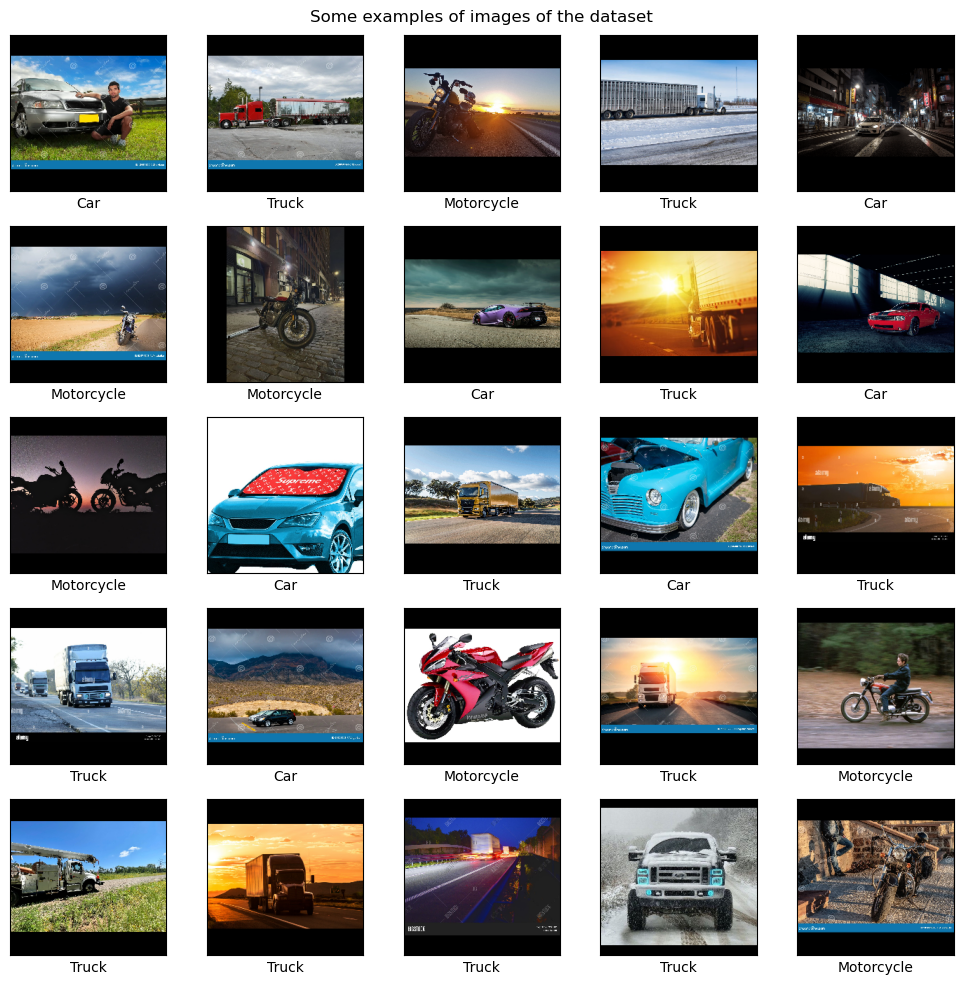

In [7]:
display_examples(train_images, train_labels, 25, randomize = False)

# Augmented Data Generation

In [8]:
def augment_image(image):
    (h, w) = image.shape[:2]
    
    # Random horizontal flip
    if np.random.rand() > 0.5:
        image = cv2.flip(image, 1)  # Flip horizontally

    # Random rotation
    angle = np.random.uniform(-150, 150)
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    image = cv2.warpAffine(image, M, (w, h))
    
    # Random scaling
    scale_factor = np.random.uniform(0.8, 1.2)
    image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor)
    
    # Random translation
    tx = np.random.uniform(-0.1 * w, 0.1 * w)
    ty = np.random.uniform(-0.1 * h, 0.1 * h)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    image = cv2.warpAffine(image, M, (w, h))
    
    # Random brightness/contrast adjustment
    alpha = np.random.uniform(0.9, 1.1)  # Contrast control
    beta = np.random.uniform(-10, 10)    # Brightness control
    image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    
    # # Adding Gaussian noise
    # noise = np.random.normal(0, 1, image.shape).astype(np.uint8)
    # image = cv2.add(image, noise)
    
    return image

In [9]:
aug_train_images, aug_train_labels = list(train_images), list(train_labels)
for image, label in zip(train_images, train_labels):
    aug_train_images.append(augment_image(image))
    aug_train_labels.append(label)
    aug_train_images.append(augment_image(image))
    aug_train_labels.append(label)
    
aug_train_images = np.array(aug_train_images, dtype='uint8')
aug_train_labels = np.array(aug_train_labels)
aug_train_images, aug_train_labels = shuffle(aug_train_images, aug_train_labels, random_state=25)

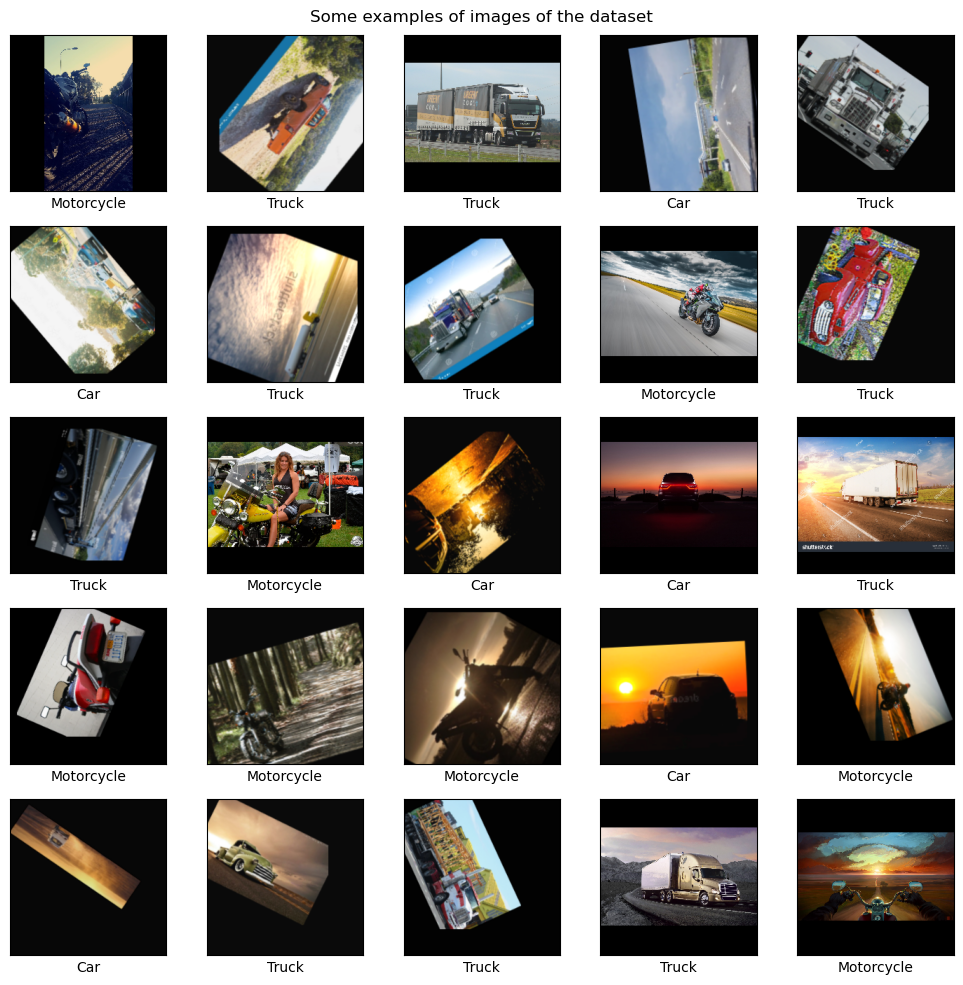

In [10]:
display_examples(aug_train_images, aug_train_labels, 25, randomize = False)

# Model Building

In [11]:
# Define ResNet model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(encoder.classes_), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    aug_train_images,aug_train_labels,
    batch_size = 32,
    epochs=10,
    validation_split=0.18,
    shuffle=True,
    callbacks=[EarlyStopping(
    monitor='val_loss',patience=3,restore_best_weights=True)]
)

# Unfreeze some layers of the base model and fine-tune
for layer in base_model.layers[:143]:
    layer.trainable = False
for layer in base_model.layers[143:]:
    layer.trainable = True

model.compile(optimizer=Adam(lr=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    aug_train_images,aug_train_labels,
    batch_size = 32,
    epochs=10,
    validation_split=0.18,
    shuffle=True,
    callbacks=[EarlyStopping(
    monitor='val_loss',patience=3,restore_best_weights=True)]
)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/15


2024-08-05 12:29:55.237182: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


64/64 [==============================] - 55s 836ms/step - loss: 1.0043 - accuracy: 0.5102 - val_loss: 0.7931 - val_accuracy: 0.6436
Epoch 2/15
64/64 [==============================] - 52s 816ms/step - loss: 0.6953 - accuracy: 0.7024 - val_loss: 0.6545 - val_accuracy: 0.7151
Epoch 3/15
64/64 [==============================] - 56s 877ms/step - loss: 0.5880 - accuracy: 0.7653 - val_loss: 0.5946 - val_accuracy: 0.7419
Epoch 4/15
64/64 [==============================] - 59s 917ms/step - loss: 0.5306 - accuracy: 0.7906 - val_loss: 0.5559 - val_accuracy: 0.7620
Epoch 5/15
64/64 [==============================] - 59s 921ms/step - loss: 0.4903 - accuracy: 0.8124 - val_loss: 0.5306 - val_accuracy: 0.7709
Epoch 6/15
64/64 [==============================] - 59s 919ms/step - loss: 0.4621 - accuracy: 0.8240 - val_loss: 0.5107 - val_accuracy: 0.7888
Epoch 7/15
64/64 [==============================] - 59s 925ms/step - loss: 0.4376 - accuracy: 0.8392 - val_loss: 0.4973 - val_accuracy: 0.7877
Epoch 8/15

# Model Prediction and Evaluation

In [14]:
predictions = model.predict(test_images) 
pred_labels = np.argmax(predictions, axis = 1) 

10/10 [==============================] - 3s 355ms/step


Accuracy: 87.713%
Precision: 87.626%
Recall: 87.756%
F1 Score: 87.66000000000001%


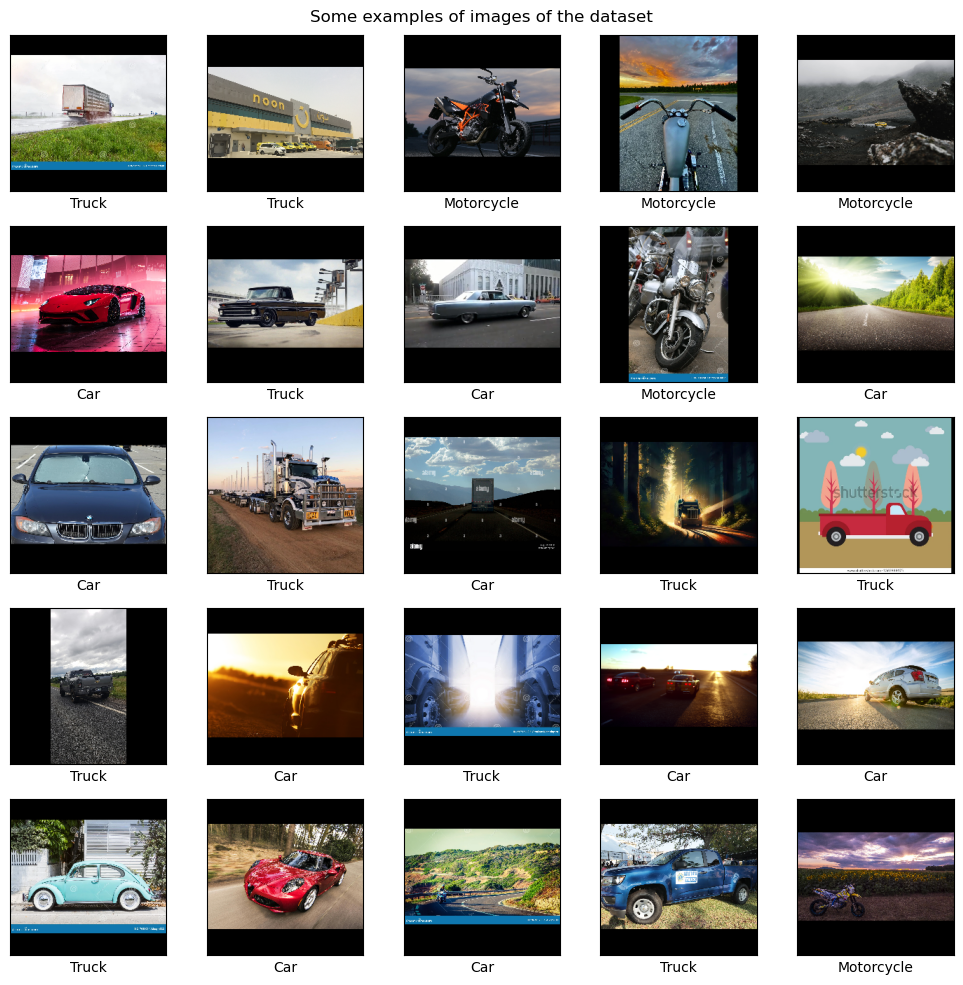

In [26]:
accuracy = accuracy_score(test_labels, pred_labels)
precision = precision_score(test_labels, pred_labels, average='macro')
recall = recall_score(test_labels, pred_labels, average='macro')
f1 = f1_score(test_labels, pred_labels, average='macro')
print(f'Accuracy: {accuracy.round(5)*100}%')
print(f'Precision: {precision.round(5)*100}%')
print(f'Recall: {recall.round(5)*100}%')
print(f'F1 Score: {f1.round(5)*100}%')
display_examples(test_images, pred_labels, num_images=25, randomize = False)

In [33]:
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83        93
           1       0.90      0.94      0.92        95
           2       0.90      0.86      0.88       105

    accuracy                           0.88       293
   macro avg       0.88      0.88      0.88       293
weighted avg       0.88      0.88      0.88       293



# Model Saving for Future Use

In [34]:
# model.save("Vehicle 3-2088.h5")